# MNIST with micrograd
In this notebook, you will implement a 2-layer (784-800-10) fully connected
feed-forward neural network for MNIST classification.

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import micrograd.nn as nn
from micrograd.engine import Value
%matplotlib inline

First, let's setup our dataset. Keras automatically splits the MNIST data into
train and test segments for us.

The "x" variables are the images, while the "y" variables are the ground truths.

In [2]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()
print(f"{train_x.shape=}\n{train_y.shape=}\n{test_x.shape=}\n{test_y.shape=}")

train_x.shape=(60000, 28, 28)
train_y.shape=(60000,)
test_x.shape=(10000, 28, 28)
test_y.shape=(10000,)


Let's visualize one of the data points:

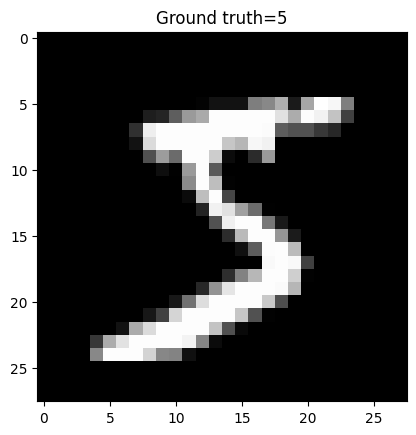

In [3]:
plt.imshow(train_x[0], cmap="gray")
plt.title(f"Ground truth={train_y[0]}");

Now that we have our data loaded, we can initialize our model, using the
abstractions we wrote in `micrograd/nn.py` (imported above as `nn`).

Remember that we are looking to create a multi-layer perceptron, with one hidden
layer of dimension 800, an input layer of 784, and output layer of 10.

Since our input dimension is now 784, we need to remember to reshape the input
images (and normalize).

In [18]:
model = nn.MLP(784, [800, 10])

train_x = train_x.reshape(-1, 784) / 255
test_x = test_x.reshape(-1, 784) / 255

Now, let's try evaluating our model on that input image from above

In [11]:
model(train_x[0]/ 255)

[Value(data=58.409956198175855, grad=0),
 Value(data=153.62140819210796, grad=0),
 Value(data=-31.466330279316168, grad=0),
 Value(data=-13.91178727868111, grad=0),
 Value(data=40.17752498761963, grad=0),
 Value(data=30.27716193699715, grad=0),
 Value(data=-35.54012374968764, grad=0),
 Value(data=16.829416356813923, grad=0),
 Value(data=-31.541346300369778, grad=0),
 Value(data=-43.18012989735118, grad=0)]

Now, of course, this returns total garbage, because our model is just running on
initialized random values for its weights. First, let's make sure that our model
is actually outputting a list of probabilities for each digit. We will use the
softmax function to do this:
$$\sigma(z)_i=\frac{\exp(z_i)}{\sum_{c=1}^C\exp(z_c)}$$
Where $C$ is number of classes (10). Implement this function below. Remember,
you are working with `Value`s, so you can only use the operations you defined
in `micrograd/engine.py`.

In [8]:
def softmax(z: list[Value], C:int=10) -> list[Value]:
  denom = sum(list(map(lambda x: x.exp(), z)))
  return list(map(lambda x: x.exp() / denom, z))

Now we can try evaluating the model again, with our new softmax function.

In [12]:
softmax(model(train_x[0]))

[Value(data=4.4688089179865774e-42, grad=0),
 Value(data=1.0, grad=0),
 Value(data=4.14396915274404e-81, grad=0),
 Value(data=1.7428406120965306e-73, grad=0),
 Value(data=5.39445430448827e-50, grad=0),
 Value(data=2.705667823222341e-54, grad=0),
 Value(data=7.05002227723166e-83, grad=0),
 Value(data=3.9083439588729283e-60, grad=0),
 Value(data=3.8444787959104507e-81, grad=0),
 Value(data=3.389830458937218e-86, grad=0)]

This looks a little better, doesn't it? Of course, it's still not an accurate
prediction, but at least it is a prediction. Now we need to worry about training
the model. 

In order to train the model, we first need to find a way to measure how wrong
its predictions are, that is we need to define our cost (loss) function. We will
use cross entropy loss, which is defined by the following equation:
$$\ell (H(x),y)=-\log\frac{\exp(H(x)_{y})}{\sum_{c=1}^C\exp(H(x)_c)}$$
Where $x$ is the input image, $H$ is our model, $y$ is the ground truth
corresponding to $x$, and $C$ is the number of classes (10). But note that this
is the same as:
$$\ell (H(x),y)=-\log(\sigma(H(x))_y)$$
Where $\sigma$ is softmax from above.

Remember that since you are working with `Value`'s you only have access to the
operations defined in `micrograd/engine.py`.

In [13]:
def loss(pred: list[Value], truth: int) -> Value:
  return -softmax(pred)[truth]

Now that our loss function is defined, finally, we can write the code for
gradient descent.

In [21]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001
for epoch in range(100):
  rp = np.random.permutation(train_x.shape[0])
  for i, indices in enumerate([rp[BATCH_SIZE * i: BATCH_SIZE * (i + 1)] for i in range(train_x.shape[0] // BATCH_SIZE)]):
    # forward
    x_batch, y_batch = train_x[indices], train_y[indices]
    scores = list(map(lambda x: softmax(model(x)), x_batch))
    losses = list(map(lambda x: loss(x, y_batch), scores))
    total_loss = sum(losses) * (1.0 / len(losses))

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    for p in model.parameters():
      p.data -= LEARNING_RATE * p.grad

    if i % 100 == 0: print(f"Epoch {epoch}, batch {i}: loss={total_loss}")

KeyboardInterrupt: 

Now that our model is trained, let's try running it on some test examples.
Try changing `SAMPLE_IDX` to see different examples.

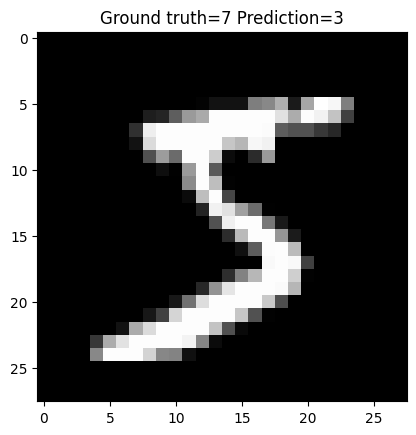

In [19]:
SAMPLE_IDX = 0

pred = softmax(model(test_x[SAMPLE_IDX]))
pred_idx = pred.index(max(pred, key=lambda x: x.data))
plt.imshow(test_x[SAMPLE_IDX].reshape(28,28), cmap="gray")
plt.title(f"Ground truth={test_y[SAMPLE_IDX]} Prediction={pred_idx}");